### S'24 795/895 DL Fundamentals Final Project

**Important**: Rename the notebook with the UID of one of the team members as the prefix, such as jdoe001_xxxxxxx.ipynb.

**Important**: Contributer:Ashish Verma

#### Description 
The task of the project is to implement CIFAR10 classification using LeNet. The second task is to use transfer learning to adapt the LeNet model trained on CIFAR10 data to STL-10.

#### Background: 
LeNet is one of the *old* CNN models. Its structure can be described as: CONV-Pooling-CONV-Pooling-FC-FC. Below is a pictorial description:

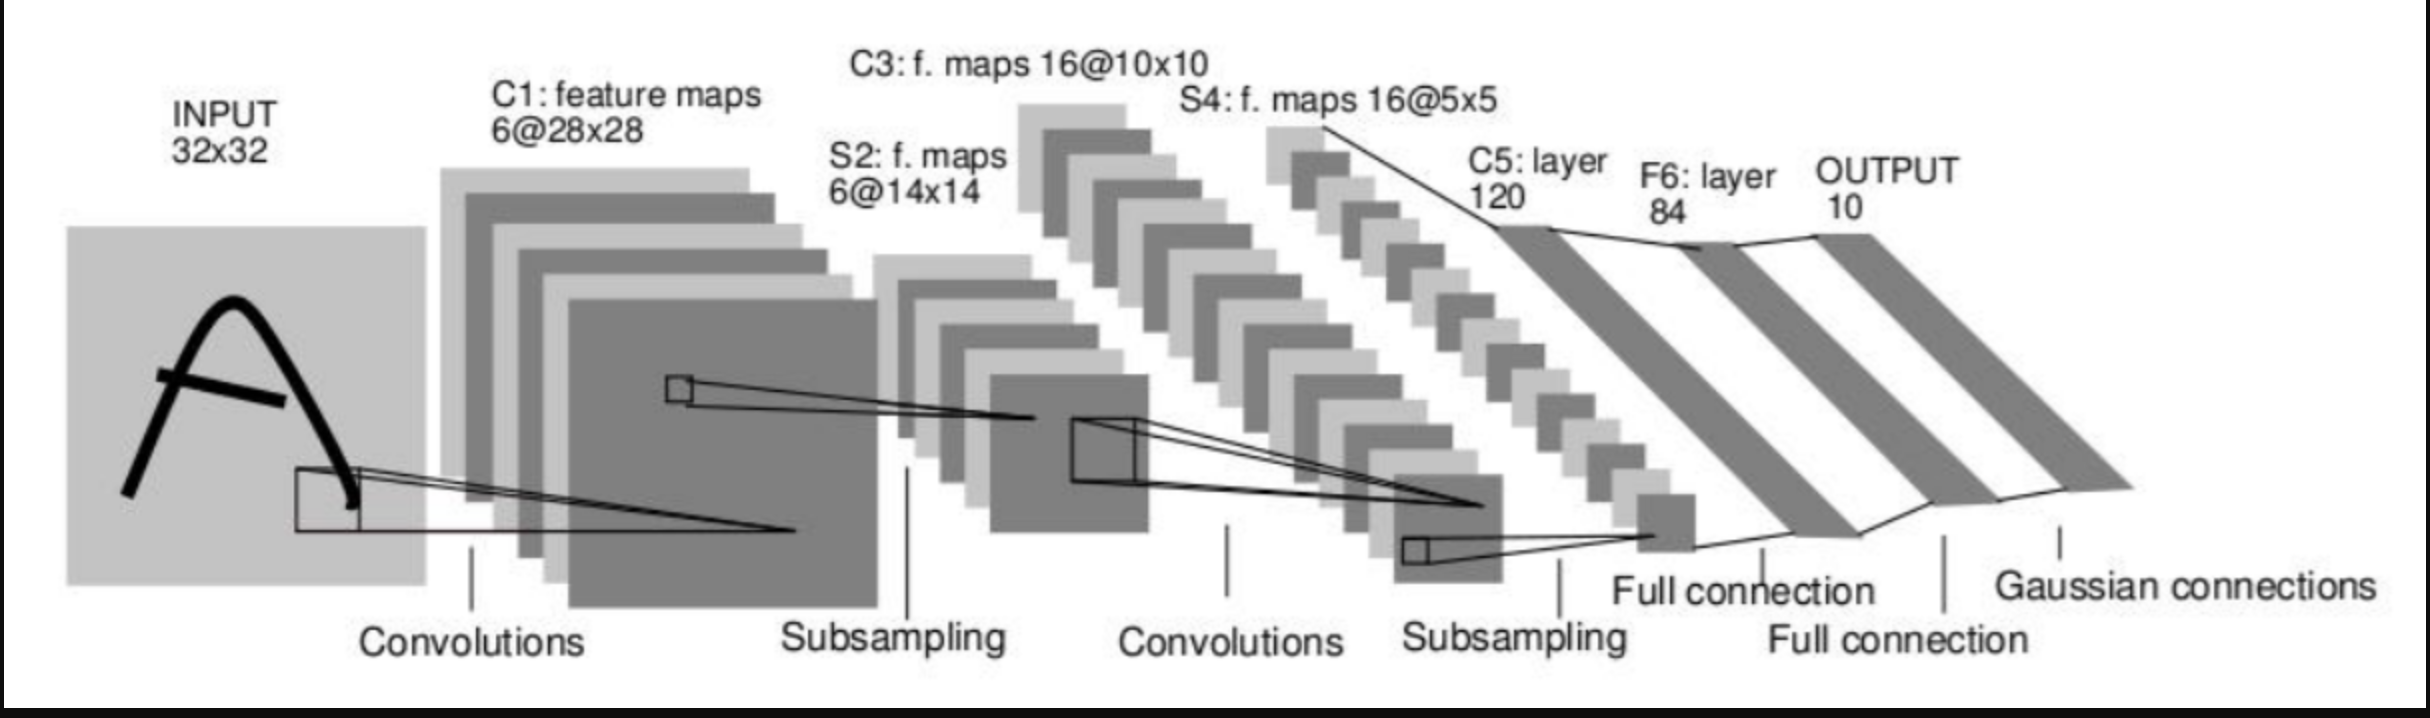

Both CIFAR10 and STL-10 are included in Torchvision. More details are at https://pytorch.org/vision/stable/datasets.html
#### Specific Requirements
1. You are required to implement it in PyTorch
2. You are required to use Dropout layers
3. You are required to use GPU.
4. You can use either colab or ODU HPC resources. It will take some time to train the model, hence I **strongly** suggest you start early.
5. You should implement it from scratch (Hint: there aren't too many examples of using LeNet for CIFAR10, so you have to write it yourself)
6. It has been reported that LeNet can achieve testing accuracy of ~65% for CIFAR10. I will accept any results with accuracy > 58% (If it's < 50%, it's acutally worse than a coin toss!)
7. You probably have to do some hyperparameter tuning to get there.
8. After the model is trained, you are required to use transfer learning method to adapt the model to STL-10 dataset. Retrain the model and achieve as good accuracy as possible.

#### Grading
1. You should implement everything in a single jupyter notebook and submit it before the deadline.
2. I recently aquired a desktop server with a beefy GPU. I **will** run your code to verify the output is correct, besides reading your pytorch code.  If your code won't run to completion, points will be deducted depending on where the failure is (the earlier the failure, the more points will be deducted).

## **Importing Pytorch Libraries**

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt

import gc
import warnings
warnings.filterwarnings('ignore')

## **Initializing GPUs**

In [2]:
#GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## **Data Augmentation and Transformations**

In [3]:
train_augmentations = transforms.Compose([transforms.RandomGrayscale(0.2),
                                          transforms.RandomHorizontalFlip(0.5),
                                          transforms.RandomVerticalFlip(0.2),
                                          transforms.RandomRotation(30),
                                          transforms.RandomAdjustSharpness(0.4),
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                                         ])

test_augmentations = transforms.Compose([transforms.ToTensor(), 
                                         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]
                                       )



##  **Data from Torchvision**

In [4]:
path = '/tmp'

train_ds = datasets.CIFAR10(root=path,
                            train=True,
                            transform=train_augmentations,
                            download=True
                           )

test_ds = datasets.CIFAR10(root=path,
                           train=False,
                           transform=test_augmentations
                           )

labels = 'airplane automobile bird cat deer dog frog horse ship truck'.split()

100%|██████████| 170498071/170498071 [00:03<00:00, 49112571.75it/s]


Extracting /tmp/cifar-10-python.tar.gz to /tmp


## **Image Visualization**

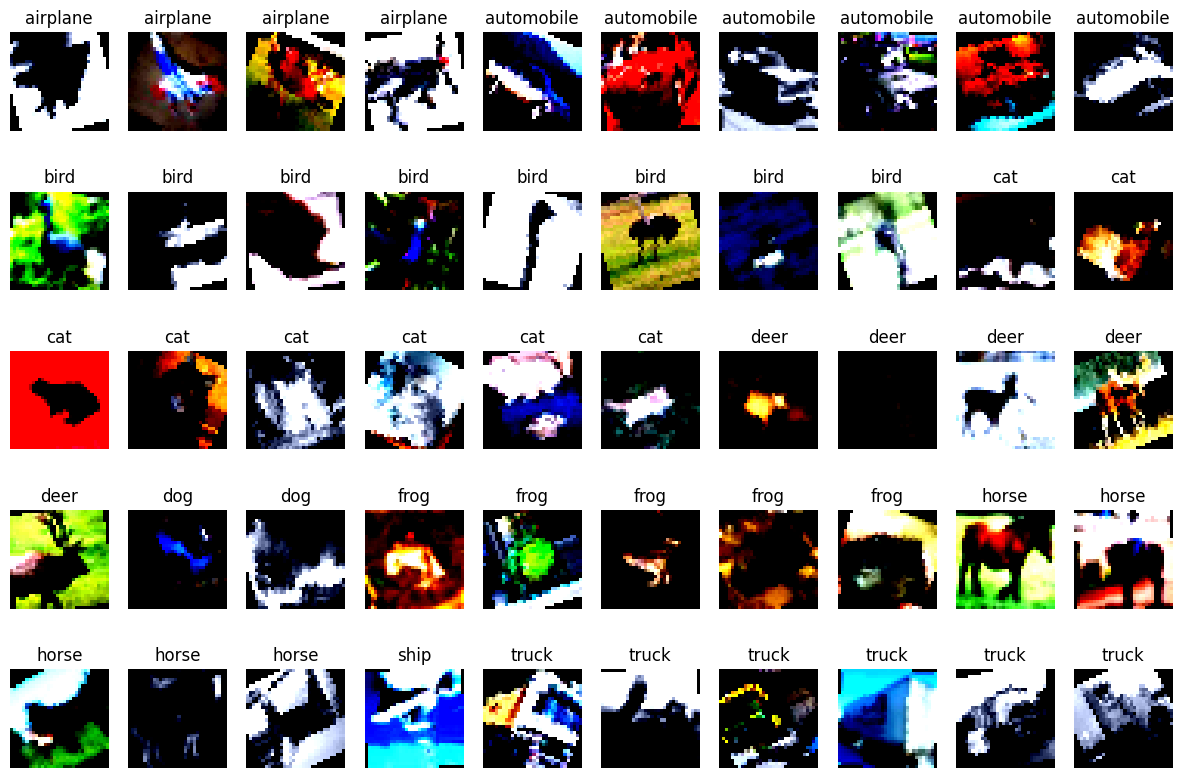

In [ ]:
first_50_samples = sorted([train_ds[i] for i in range(50)], key=lambda x:x[1])

figure = plt.figure(figsize=(15,10))
for i in range(1,51):
    img = first_50_samples[i-1][0].permute(1,2,0)
    label = labels[first_50_samples[i-1][1]]
    figure.add_subplot(5,10,i)
    plt.title(label)
    plt.axis('off')
    plt.imshow(img)

# **Class Config**

In [ ]:
class Config:
    lr=1e-3
    epochs=15
    optim=torch.optim.Adam
    batch_size=64

## **DataLoaders**

In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_ds, batch_size=Config.batch_size, shuffle=True, num_workers=2)
valid_dataloader = torch.utils.data.DataLoader(test_ds, batch_size=Config.batch_size, shuffle=True, num_workers=2)

## **The LeNET Model**

In [ ]:
class LeNet(nn.Module):
    
    def __init__(self, in_features=3, num_classes=10):
        super(LeNet, self).__init__()
        
        self.conv_block = nn.Sequential(nn.Conv2d(in_channels=in_features,
                                                   out_channels=6,
                                                   kernel_size=5,
                                                   stride=1),
                                         nn.ReLU(),
                                         nn.MaxPool2d(2,2),
                                         nn.Dropout(0.2), 
                                         nn.Conv2d(in_channels=6,
                                                   out_channels=16,
                                                   kernel_size=5,
                                                   stride=1),
                                         nn.ReLU(),
                                         nn.MaxPool2d(2,2)
                                        )
        
        self.linear_block = nn.Sequential( nn.Linear(16*5*5, 120),
                                           nn.ReLU(),
                                           nn.Linear(120,84),
                                           nn.ReLU(),
                                           nn.Linear(84,10)
                                         )
        
    def forward(self, x):
        x = self.conv_block(x)
        x = torch.flatten(x,1)
        x = self.linear_block(x)
        return x

In [ ]:
model = LeNet().to(device)
print(model)

## **Training** 

In [ ]:
class Trainer:
    def __init__(self, model, dataloaders, device):
        self.model = model
        self.train_loader, self.valid_loader = dataloaders
        self.loss_fn = nn.CrossEntropyLoss()
        self.optim = Config.optim(self.model.parameters(), lr = Config.lr)
        self.device = device
        
    def accuracy(self, output, y):
        pred_labels = torch.argmax(output, dim=1)
        return (pred_labels == y).sum().item() / len(y)
        
    def train_one_epoch(self):
        
        running_loss = 0
        running_acc = 0
        
        for x,y in self.train_loader:
            
            self.optim.zero_grad()
            
            x = x.to(self.device, dtype=torch.float)
            y = y.to(self.device, dtype=torch.long)
            
            output = self.model(x)
            
            loss = self.loss_fn(output, y)
            
            loss.backward()
            self.optim.step()
            
            running_loss += loss.item()
            running_acc += self.accuracy(output,y)
            
            del x,y,output
            
        train_loss = running_loss/len(self.train_loader)
        train_acc = running_acc/len(self.train_loader)
        
        return train_loss, train_acc
    
    @torch.no_grad()
    def valid_one_epoch(self):
        
        running_loss = 0
        running_acc = 0
        
        for x,y in self.valid_loader:
            
            x = x.to(self.device, dtype=torch.float)
            y = y.to(self.device, dtype=torch.long)
            
            output = self.model(x)
            
            loss = self.loss_fn(output, y)
            
            running_loss += loss.item()
            running_acc += self.accuracy(output,y)
            
            del x,y,output
            
        valid_loss = running_loss/len(self.valid_loader)
        valid_acc = running_acc/len(self.valid_loader)
        
        return valid_loss, valid_acc
    
    
    def fit(self):
        print(f"Model is using {'cuda' if next(self.model.parameters()).is_cuda else 'cpu'}")
        train_losses,train_accs = [], []
        valid_losses, valid_accs = [], []
        
        for epoch in range(Config.epochs):
            
            self.model.train()
            
            train_loss, train_acc = self.train_one_epoch()
            train_losses.append(train_loss)
            train_accs.append(train_acc)
            
            self.model.eval()
            
            valid_loss, valid_acc = self.valid_one_epoch()
            valid_losses.append(valid_loss)
            valid_accs.append(valid_acc)
            
            print(f"------EPOCH {epoch+1}/{Config.epochs}------")
            print(f"Training: LOSS: {train_loss:.4f} | ACCURACY: {train_acc:.4f}")
            print(f"Validation: LOSS: {valid_loss:.4f} | ACCURACY: {valid_acc:.4f}\n\n")
            
            # CLEANUP
            gc.collect()
            torch.cuda.empty_cache()
            
        
        return (train_losses, train_accs), (valid_losses, valid_accs)

In [11]:
trainer = Trainer(model, (train_dataloader, valid_dataloader), device)

(train_losses, train_accs), (valid_losses, valid_accs) = trainer.fit()

------EPOCH 1/15------
Training: LOSS: 1.8340 | ACCURACY: 0.3281
Validation: LOSS: 1.5451 | ACCURACY: 0.4415


------EPOCH 2/15------
Training: LOSS: 1.6462 | ACCURACY: 0.3998
Validation: LOSS: 1.4467 | ACCURACY: 0.4640


------EPOCH 3/15------
Training: LOSS: 1.5733 | ACCURACY: 0.4301
Validation: LOSS: 1.3583 | ACCURACY: 0.5103


------EPOCH 4/15------
Training: LOSS: 1.5196 | ACCURACY: 0.4533
Validation: LOSS: 1.3036 | ACCURACY: 0.5343


------EPOCH 5/15------
Training: LOSS: 1.4919 | ACCURACY: 0.4622
Validation: LOSS: 1.3282 | ACCURACY: 0.5168


------EPOCH 6/15------
Training: LOSS: 1.4585 | ACCURACY: 0.4759
Validation: LOSS: 1.2753 | ACCURACY: 0.5348


------EPOCH 7/15------
Training: LOSS: 1.4451 | ACCURACY: 0.4850
Validation: LOSS: 1.2540 | ACCURACY: 0.5475


------EPOCH 8/15------
Training: LOSS: 1.4251 | ACCURACY: 0.4914
Validation: LOSS: 1.2421 | ACCURACY: 0.5518


------EPOCH 9/15------
Training: LOSS: 1.4049 | ACCURACY: 0.4958
Validation: LOSS: 1.2300 | ACCURACY: 0.5571


-

## **Plot Losses**

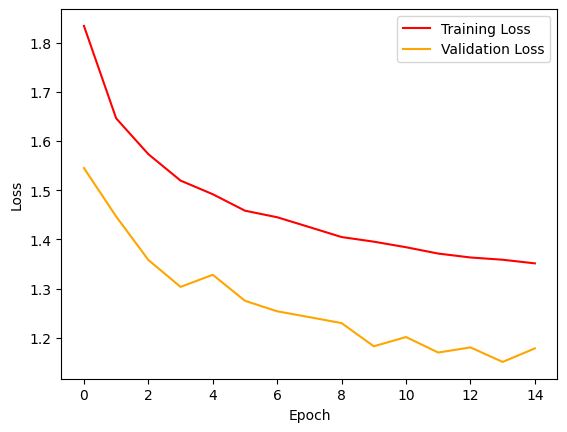

In [12]:
plt.plot(train_losses, color='red', label='Training Loss')
plt.plot(valid_losses, color='orange', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## **Plot Accuracy**

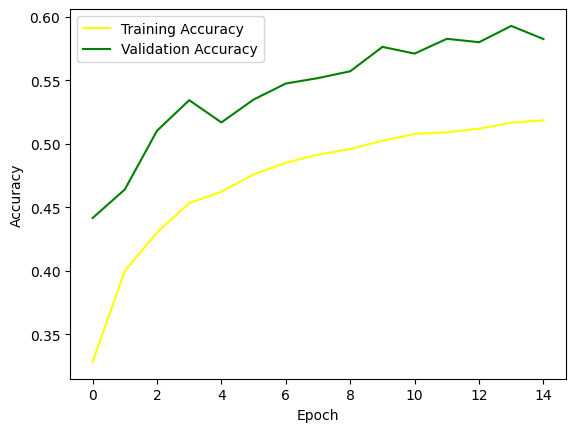

In [13]:
plt.plot(train_accs, color='yellow', label='Training Accuracy')
plt.plot(valid_accs, color='green', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# **Save Model**

In [ ]:
## save model for later use
torch.save(model.state_dict(), './lenet_cifar10.pt')

In [ ]:
!ls -al *.pt

-rw-r--r-- 1 root root 252108 Apr 10 19:15 lenet_cifar10.pt


# **Load Model**

In [ ]:
model.load_state_dict(torch.load('./lenet_cifar10.pt'))
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
conv_block.0.weight 	 torch.Size([6, 3, 5, 5])
conv_block.0.bias 	 torch.Size([6])
conv_block.4.weight 	 torch.Size([16, 6, 5, 5])
conv_block.4.bias 	 torch.Size([16])
linear_block.0.weight 	 torch.Size([120, 400])
linear_block.0.bias 	 torch.Size([120])
linear_block.2.weight 	 torch.Size([84, 120])
linear_block.2.bias 	 torch.Size([84])
linear_block.4.weight 	 torch.Size([10, 84])
linear_block.4.bias 	 torch.Size([10])


# **Data Transformation on STL-10**

In [ ]:
train_augmentations_stl = transforms.Compose([transforms.RandomGrayscale(0.2),
                                          transforms.RandomHorizontalFlip(0.5),
                                          transforms.RandomVerticalFlip(0.2),
                                          transforms.Resize((32, 32)),    
                                          transforms.RandomRotation(30),
                                          transforms.RandomAdjustSharpness(0.4),
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                                         ])

test_augmentations_stl = transforms.Compose([transforms.ToTensor(), 
                                        transforms.Resize((32, 32)),
                                         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]
                                       )

# **Transfer Learning on STL-10**

In [ ]:
train_ds_stl = datasets.STL10(root='./data', split='train', download=True, transform=train_augmentations_stl)
test_ds_stl = datasets.STL10(root='./data', split='test', download=True, transform=test_augmentations_stl)


100%|██████████| 2640397119/2640397119 [01:31<00:00, 28850562.30it/s]


Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified


# **STL-10 Image Visualization**

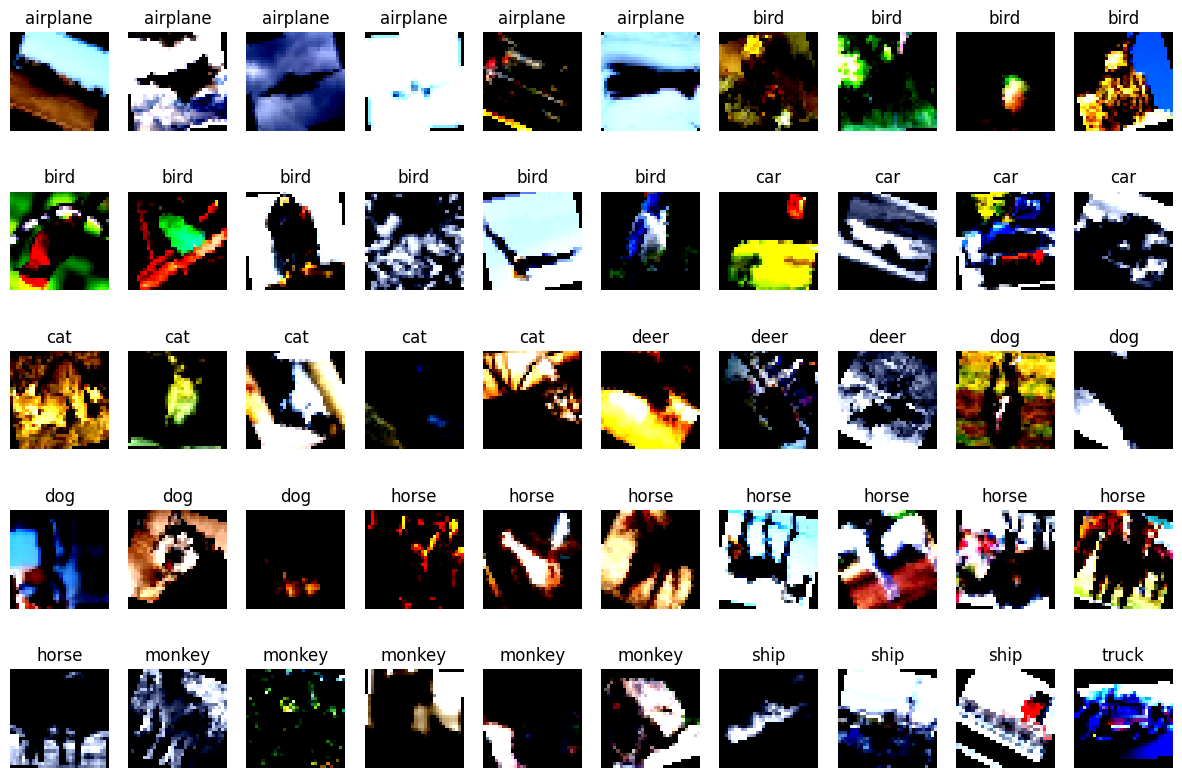

In [ ]:
first_50_samples = sorted([train_ds_stl[i] for i in range(50)], key=lambda x:x[1])

figure = plt.figure(figsize=(15,10))
for i in range(1,51):
    img = first_50_samples[i-1][0].permute(1,2,0)
    label = train_ds_stl.classes[first_50_samples[i-1][1]]
    figure.add_subplot(5,10,i)
    plt.title(label)
    plt.axis('off')
    plt.imshow(img)

# **STL-10 DataLoader**

In [ ]:
train_dataloader_stl = torch.utils.data.DataLoader(train_ds_stl, batch_size=32, shuffle=True, num_workers=2)
valid_dataloader_stl = torch.utils.data.DataLoader(test_ds_stl, batch_size=32, shuffle=True, num_workers=2)

# **Create object for STL-10**

In [ ]:
model_stl = LeNet().to(device)
print(model)

LeNet(
  (conv_block): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_block): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)


# **Load CIFAR-10 for STL-10**

In [ ]:
# Load the weights from the trained CIFAR-10 model to the STL-10 model
model_stl.load_state_dict(model.state_dict())

<All keys matched successfully>

# **Update the last layer to match the number of classes in STL-10**

In [ ]:
# Modify the output layer to match the number of classes in STL-10
#num_classes_stl = len(train_ds_stl.classes)
#model_stl.linear_block = nn.Linear(84, num_classes_stl).to(device)

# **Train the STL-10 model**

In [ ]:
class Trainer_STL:
    def __init__(self, model, dataloaders, device):
        
        self.config = {
            'lr':1e-2,
            'epochs': 15
        }
        
        self.model = model
        self.train_loader, self.valid_loader = dataloaders
        self.loss_fn = nn.CrossEntropyLoss()
        self.optim = torch.optim.Adam(self.model.parameters(), lr = self.config['lr'])
        self.device = device
        
    def accuracy(self, output, y):
        pred_labels = torch.argmax(output, dim=1)
        return (pred_labels == y).sum().item() / len(y)
        
    def train_one_epoch(self):
        
        running_loss = 0
        running_acc = 0
        
        for x,y in self.train_loader:
            
            self.optim.zero_grad()
            
            x = x.to(self.device, dtype=torch.float)
            y = y.to(self.device, dtype=torch.long)
            
            output = self.model(x)
            
            loss = self.loss_fn(output, y)
            
            loss.backward()
            self.optim.step()
            
            running_loss += loss.item()
            running_acc += self.accuracy(output,y)
            
            del x,y,output
            
        train_loss = running_loss/len(self.train_loader)
        train_acc = running_acc/len(self.train_loader)
        
        return train_loss, train_acc
    
    @torch.no_grad()
    def valid_one_epoch(self):
        
        running_loss = 0
        running_acc = 0
        
        for x,y in self.valid_loader:
            
            x = x.to(self.device, dtype=torch.float)
            y = y.to(self.device, dtype=torch.long)
            
            output = self.model(x)
            
            loss = self.loss_fn(output, y)
            
            running_loss += loss.item()
            running_acc += self.accuracy(output,y)
            
            del x,y,output
            
        valid_loss = running_loss/len(self.valid_loader)
        valid_acc = running_acc/len(self.valid_loader)
        
        return valid_loss, valid_acc
    
    
    def fit(self):
        
        train_losses,train_accs = [], []
        valid_losses, valid_accs = [], []
        
        for epoch in range(self.config['epochs']):
            
            print(f"Model is using {'cuda' if next(self.model.parameters()).is_cuda else 'cpu'}")
            
            self.model.train()
            
            train_loss, train_acc = self.train_one_epoch()
            train_losses.append(train_loss)
            train_accs.append(train_acc)
            
            self.model.eval()
            
            valid_loss, valid_acc = self.valid_one_epoch()
            valid_losses.append(valid_loss)
            valid_accs.append(valid_acc)
            
            print(f"------EPOCH {epoch+1}/{self.config['epochs']}------")
            print(f"Training: LOSS: {train_loss:.4f} | ACCURACY: {train_acc:.4f}")
            print(f"Validation: LOSS: {valid_loss:.4f} | ACCURACY: {valid_acc:.4f}\n\n")
            
            # CLEANUP
            gc.collect()
            torch.cuda.empty_cache()
            
        
        return (train_losses, train_accs), (valid_losses, valid_accs)

In [ ]:
trainer_stl = Trainer_STL(model_stl, (train_dataloader_stl, valid_dataloader_stl), device)
(train_losses_stl, train_accs_stl), (valid_losses_stl, valid_accs_stl) = trainer_stl.fit()

Model is using cuda
------EPOCH 1/15------
Training: LOSS: 1.9870 | ACCURACY: 0.2456
Validation: LOSS: 2.0268 | ACCURACY: 0.2706


Model is using cuda
------EPOCH 2/15------
Training: LOSS: 1.8972 | ACCURACY: 0.2735
Validation: LOSS: 1.7770 | ACCURACY: 0.2989


Model is using cuda
------EPOCH 3/15------
Training: LOSS: 1.8572 | ACCURACY: 0.2902
Validation: LOSS: 1.7969 | ACCURACY: 0.3043


Model is using cuda
------EPOCH 4/15------
Training: LOSS: 1.8046 | ACCURACY: 0.3103
Validation: LOSS: 1.7821 | ACCURACY: 0.3199


Model is using cuda
------EPOCH 5/15------
Training: LOSS: 1.8306 | ACCURACY: 0.2938
Validation: LOSS: 1.7429 | ACCURACY: 0.3031


Model is using cuda
------EPOCH 6/15------
Training: LOSS: 1.8403 | ACCURACY: 0.2930
Validation: LOSS: 1.7612 | ACCURACY: 0.2815


Model is using cuda
------EPOCH 7/15------
Training: LOSS: 1.7960 | ACCURACY: 0.3063
Validation: LOSS: 1.7880 | ACCURACY: 0.2963


Model is using cuda
------EPOCH 8/15------
Training: LOSS: 1.7904 | ACCURACY: 0.307

# **Plot STL Losses**

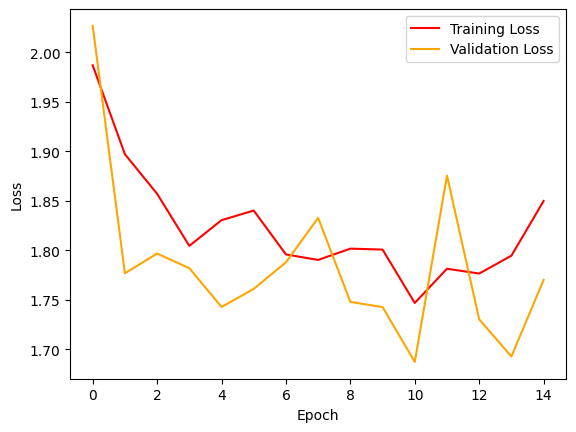

In [ ]:
plt.plot(train_losses_stl, color='red', label='Training Loss')
plt.plot(valid_losses_stl, color='orange', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# **Plot STL Accuracies**

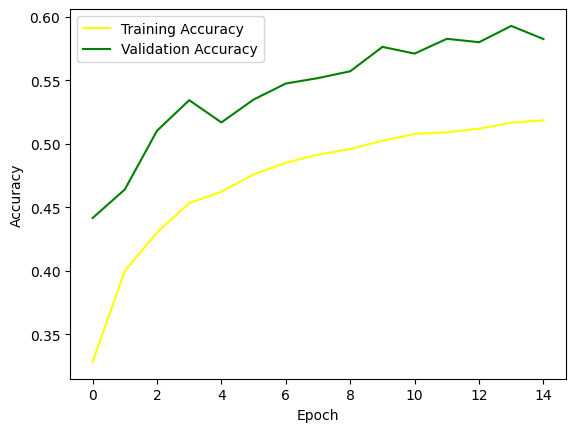

In [ ]:
plt.plot(train_accs, color='yellow', label='Training Accuracy')
plt.plot(valid_accs, color='green', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
## save model for later use
torch.save(model_stl.state_dict(), './lenet_tranfer_stl10.pt')